In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import kagglehub

# Download Dataset for Lyft

In [2]:
path = kagglehub.dataset_download("ravi72munde/uber-lyft-cab-prices")

print("Path to dataset files:", path)

100%|██████████| 73.5M/73.5M [00:02<00:00, 35.6MB/s]

Extracting files...


Path to dataset files: C:\Users\O_s\.cache\kagglehub\datasets\ravi72munde\uber-lyft-cab-prices\versions\4


# Download Dataset for Weather Condition

In [3]:
path = kagglehub.dataset_download("ravi72munde/uber-lyft-cab-prices")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\O_s\.cache\kagglehub\datasets\ravi72munde\uber-lyft-cab-prices\versions\4


# Import Data

In [2]:
df_rides = pd.read_csv('C:/Users/O_s/.cache/kagglehub/datasets/ravi72munde/uber-lyft-cab-prices/versions/4/cab_rides.csv')
df_weather = pd.read_csv('C:/Users/O_s/.cache/kagglehub/datasets/ravi72munde/uber-lyft-cab-prices/versions/4/weather.csv')

# DATA PREPROCESSING

In [3]:
# Unifing timestamp format and turn to datetime
df_rides['date_time'] = pd.to_datetime(df_rides['time_stamp']/1000, unit='s')
df_weather['date_time'] = pd.to_datetime(df_weather['time_stamp'], unit='s')
# Merging info location-date-hour wise
df_rides['loc_date_hr'] = df_rides['source'].astype(str) + " - " + df_rides['date_time'].dt.date.astype(str) + " - " + df_rides['date_time'].dt.hour.astype(str)
df_weather['loc_date_hr'] = df_weather['location'].astype(str) + " - " + df_weather['date_time'].dt.date.astype(str) + " - " + df_weather['date_time'].dt.hour.astype(str)

In [5]:
# Grouping the weather by the location and datetime
weather = df_weather.groupby(['loc_date_hr']).agg({'temp': 'mean', 'clouds': 'mean', 'pressure': 'mean', 'rain': 'mean', 'humidity': 'mean', 'wind': 'mean'}).reset_index()
weather['location'] = df_weather.groupby(['loc_date_hr'])['location'].first().values
weather.index = weather['loc_date_hr']
weather['rain'].fillna(0,inplace=True)

C:\Users\O_s\AppData\Local\Temp\ipykernel_14272\3271734649.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather['rain'].fillna(0,inplace=True)


In [6]:
# Merging the both dataset into one using on 'loc_date_hr'
merged_df = df_rides.join(weather,on=['loc_date_hr'],rsuffix ='_w')
merged_df.dropna(inplace=True)

In [7]:
#getting hour as separate feature
merged_df['hour'] = merged_df['date_time'].dt.hour.astype(int)
def categorize_time(hour):
    if 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 22:
        return 'Night'
    elif hour == 23 or hour == 0 or hour == 1:
        return 'Late Night'
    elif 2 <= hour <= 5:
        return 'Late Night'

merged_df['day_time'] = merged_df['hour'].apply(categorize_time)

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 635242 entries, 0 to 693070
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   distance          635242 non-null  float64       
 1   cab_type          635242 non-null  object        
 2   time_stamp        635242 non-null  int64         
 3   destination       635242 non-null  object        
 4   source            635242 non-null  object        
 5   price             635242 non-null  float64       
 6   surge_multiplier  635242 non-null  float64       
 7   id                635242 non-null  object        
 8   product_id        635242 non-null  object        
 9   name              635242 non-null  object        
 10  date_time         635242 non-null  datetime64[ns]
 11  loc_date_hr       635242 non-null  object        
 12  loc_date_hr_w     635242 non-null  object        
 13  temp              635242 non-null  float64       
 14  clouds   

In [9]:
merged_df.drop(columns=['id','product_id','time_stamp','location','date_time','loc_date_hr','loc_date_hr_w','hour'],axis=1,inplace=True)

In [10]:
merged_df.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,temp,clouds,pressure,rain,humidity,wind,day_time
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,Shared,38.460,0.290000,1022.25,0.000,0.760000,7.68,Morning
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux,44.065,0.995000,1002.88,0.106,0.895000,12.63,Late Night
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,Lux Black XL,35.080,0.000000,1013.71,0.000,0.700000,5.25,Late Night
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,Lyft XL,37.680,0.433333,998.42,0.000,0.706667,11.16,Late Night
5,0.44,Lyft,North Station,Haymarket Square,16.5,1.0,Lux Black,40.780,0.930000,1000.15,0.000,0.790000,7.55,Night


In [11]:
#Separating Cab services into Lyft and Uber
# Subsetting dataframe into uber and lyft
df_lyft = merged_df[merged_df['cab_type']=='Lyft'].copy()
df_uber = merged_df[merged_df['cab_type']=='Uber'].copy()

In [12]:
#Separating features and target
X_lyft = df_lyft.drop('price',axis=1)
y_lyft = df_lyft['price'].copy()

X_uber = df_uber.drop('price',axis=1)
y_uber = df_uber['price'].copy()

In [ ]:
X_lyft.head()

,distance,cab_type,destination,source,surge_multiplier,name,temp,clouds,pressure,rain,humidity,wind,day_time
0,0.44,Lyft,North Station,Haymarket Square,1.0,Shared,38.460,0.290000,1022.25,0.000,0.760000,7.68,Morning
1,0.44,Lyft,North Station,Haymarket Square,1.0,Lux,44.065,0.995000,1002.88,0.106,0.895000,12.63,Late Night
3,0.44,Lyft,North Station,Haymarket Square,1.0,Lux Black XL,35.080,0.000000,1013.71,0.000,0.700000,5.25,Late Night
4,0.44,Lyft,North Station,Haymarket Square,1.0,Lyft XL,37.680,0.433333,998.42,0.000,0.706667,11.16,Late Night
5,0.44,Lyft,North Station,Haymarket Square,1.0,Lux Black,40.780,0.930000,1000.15,0.000,0.790000,7.55,Night


In [26]:
# Creating preprocessing pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [18]:
#Converting data into machine understandable language
str_attributes = ["cab_type", "destination", "source", "name", "day_time"]
num_attributes = ["distance", "temp", "clouds", "pressure", "rain", "humidity", "wind","surge_multiplier"]

pipeline = ColumnTransformer([
        ("str", OneHotEncoder(drop="first"), str_attributes),
        ("num", StandardScaler(), num_attributes),])

pipeline

ColumnTransformer(transformers=[('str', OneHotEncoder(drop='first'),
                                 ['cab_type', 'destination', 'source', 'name',
                                  'day_time']),
                                ('num', StandardScaler(),
                                 ['distance', 'temp', 'clouds', 'pressure',
                                  'rain', 'humidity', 'wind',
                                  'surge_multiplier'])])

# Train Test Split

In [19]:
X_train_lyft, X_test_lyft, y_train_lyft, y_test_lyft = train_test_split(X_lyft, y_lyft, test_size=0.2, random_state=42)

X_train_lyft_prepared = pipeline.fit_transform(X_train_lyft)

# Random Forest

In [20]:
#Training the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
model = make_pipeline(pipeline,RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train_lyft, y_train_lyft)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('str',
                                                  OneHotEncoder(drop='first'),
                                                  ['cab_type', 'destination',
                                                   'source', 'name',
                                                   'day_time']),
                                                 ('num', StandardScaler(),
                                                  ['distance', 'temp', 'clouds',
                                                   'pressure', 'rain',
                                                   'humidity', 'wind',
                                                   'surge_multiplier'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [23]:
# Predict and calculate the metrics
y_pred = model.predict(X_test_lyft)

# Calculate Mean Squared Error and then take the square root for RMSE
mse = mean_squared_error(y_test_lyft, y_pred)
rmse = np.sqrt(mse)

# Calculate R^2 Score
r2 = r2_score(y_test_lyft, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 2.0714286547822067
Root Mean Squared Error: 1.4392458632152487
R^2 Score: 0.9792396362494343


# Gradient Boosting

In [24]:
# By using gradientboosting model
from sklearn.ensemble import GradientBoostingRegressor

# Create a new model with GradientBoostingRegressor
model_gbr = make_pipeline(pipeline, GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))

# Training the model with Lyft data as an example
model_gbr.fit(X_train_lyft, y_train_lyft)
# Predicting the prices for Lyft
y_pred_lyft_gbr = model_gbr.predict(X_test_lyft)

In [25]:
# Calculate metrics for Lyft with Gradient Boosting Regressor
mse_lyft_gbr = mean_squared_error(y_test_lyft, y_pred_lyft_gbr)
rmse_lyft_gbr = np.sqrt(mse_lyft_gbr)
r2_lyft_gbr = r2_score(y_test_lyft, y_pred_lyft_gbr)

print(f"Gradient Boosting - Lyft - Mean Squared Error: {mse_lyft_gbr}")
print(f"Gradient Boosting - Lyft - Root Mean Squared Error: {rmse_lyft_gbr}")
print(f"Gradient Boosting - Lyft - R^2 Score: {r2_lyft_gbr}")

Gradient Boosting - Lyft - Mean Squared Error: 2.4424127677320633
Gradient Boosting - Lyft - Root Mean Squared Error: 1.5628220524845633
Gradient Boosting - Lyft - R^2 Score: 0.9755215428877638


# KNN

In [28]:
models = {
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
}
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, dataset_name):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict using the model
    y_pred = model.predict(X_test)
    
    # Calculate Mean Squared Error and then take the square root for RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Calculate R^2 Score
    r2 = r2_score(y_test, y_pred)
    
    # Print the evaluation metrics
    print(f"{model_name} - {dataset_name} - Mean Squared Error: {mse}")
    print(f"{model_name} - {dataset_name} - Root Mean Squared Error: {rmse}")
    print(f"{model_name} - {dataset_name} - R² Score: {r2}")

# Example usage:
# Assuming `models` is a dictionary of sklearn model instances
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', handle_unknown="ignore")
X_train_lyft_encoded = encoder.fit_transform(X_train_lyft)
X_test_lyft_encoded = encoder.transform(X_test_lyft)

# Apply each model to the Lyft dataset
for model_name, model in models.items():
    print(f"Applying {model_name}:")
    evaluate_model(model_name, model, X_train_lyft_encoded, y_train_lyft, X_test_lyft_encoded, y_test_lyft, "Lyft")


Applying K-Nearest Neighbors:
K-Nearest Neighbors - Lyft - Mean Squared Error: 51.45117954806357
K-Nearest Neighbors - Lyft - Root Mean Squared Error: 7.172947758631982
K-Nearest Neighbors - Lyft - R² Score: 0.484343715943348


# Graphical Representation

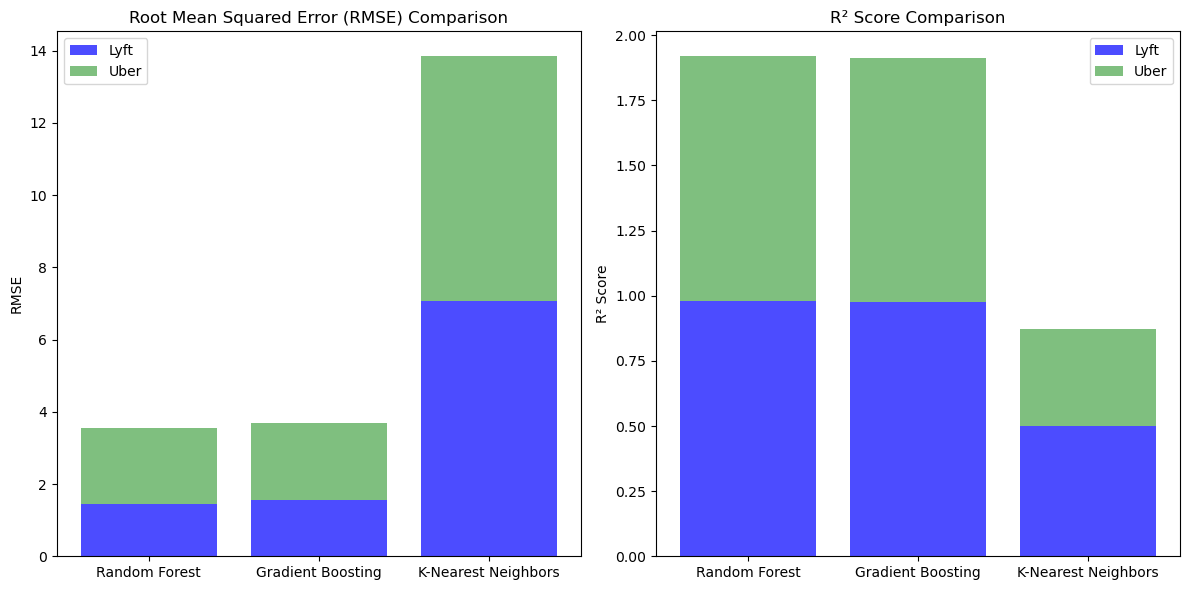

In [29]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['Random Forest', 'Gradient Boosting', 'K-Nearest Neighbors']
rmse_lyft = [1.439, 1.563, 7.071]
r2_lyft = [0.979, 0.976, 0.499]
rmse_uber = [2.102, 2.127, 6.771]
r2_uber = [0.940, 0.938, 0.374]

# Plotting the Root Mean Squared Error (RMSE)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, rmse_lyft, color='blue', alpha=0.7, label='Lyft')
plt.bar(models, rmse_uber, color='green', alpha=0.5, label='Uber', bottom=rmse_lyft)
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.ylabel('RMSE')
plt.legend()

# Plotting the R² Scores
plt.subplot(1, 2, 2)
plt.bar(models, r2_lyft, color='blue', alpha=0.7, label='Lyft')
plt.bar(models, r2_uber, color='green', alpha=0.5, label='Uber', bottom=r2_lyft)
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
plt.show()